## 3. Hero-wise Skill Analysis Based On Linear Regression


### 3.1 Data Cleansing

Before we start our process of modeling, there are some steps we should do, data cleaning is one of the important part.

Data cleansing is the process of replacing raw data with higher quality usable data, and is a crucial part of data pre-processing, the quality of the cleaned data largely determines the accuracy of the results of analysis.

The data set of heroes statistic we use is in a tiled continuous table with every single stat amount, which is detailed enough to have redundant parts including non-essential information and some data that will affect the accuracy of the results. So, our first step is to delete these content.

After that the analysis starts. We first assume that each data is highly positively correlated with the results. Therefore, we tried simple Linear Regression to map the hero-wise skills with their winning rate in the OWL season 2019-2020.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

function name: pre_cleansing

Description:

The function cleans the match statistics data and removes the ones that have low to no information for a given match。

Input:

1. Match_stats [DataFrame]: It includes all the players' information for all matches of a given year.

Output:

1. Match_stats_sanitized [DataFrame]: It includes the cleaned data.

The dataset we use about hero data is composed of the values that can be collected for each hero used by each player, for each match.

Since in Overwatch, it is possible to change characters after death, so there are cases where the character dies quickly after changing. In these cases, many values cannot be measured. And for a hero only lived for a moment, the contribution they did to the game is negligible.

Therefore, we tried to exclude such cases from the data based on how to judge a range of table should be drop or not.

Here we use two metrics as parameters to measure and judge: player survival time and the number of retained record data.

In [2]:
def data_pre_cleansing(Match_stats):    
    drop_list =[]
    hero = Match_stats.loc[0,'hero']
    flag = False

    # Delete range
    range_begin = 0
    range_end = 0

    for index, row in Match_stats.iterrows():
        # If Alive Time < 30 sec
        if(row.stat_name == 'Time Alive'):
            if(row.stat_amount < 30):
                flag = True
        if(row.stat_name == 'Time Played'):
            if(row.stat_amount < 30):
                flag = True        

        if(row.hero!= hero):
            hero = row.hero
            range_end = index-1

        # If stat less than 6
            if((range_end-range_begin+1)< 6): 
                flag = True

            if(flag):
                # print(range_begin,'-',range_end)
                drop_list.append((range_begin,range_end))
            range_begin = index
            flag = False
        if index == Match_stats.index[-1]:
            if(flag):
                drop_list.append((range_begin,index))
    return drop_list

def drop_data(list,data):
    full_drop_list = []
    for pair in list:
        for x in range(pair[0],pair[1]): 
            full_drop_list.append(x)
    return data.drop(full_drop_list,axis=0)

def pre_cleansing(Match_stats):
    drop_list = data_pre_cleansing(Match_stats)
    return drop_data(drop_list,Match_stats) 

To find out the specific threshold of how long do they live in digital should we ignore about?

In that case, we plot all the played time for games and try to find out by that.

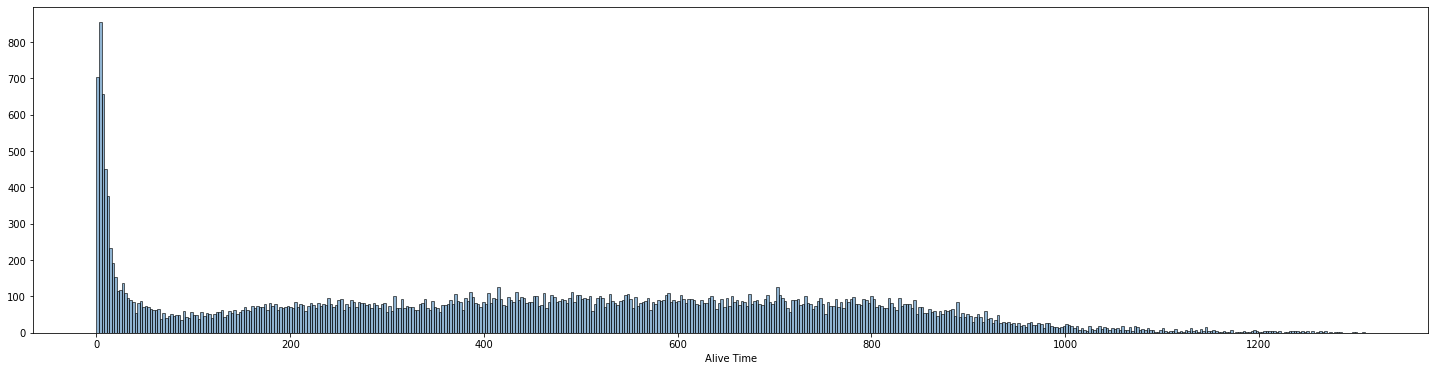

In [35]:
phs_2021 = pd.read_csv('Data/phs_2021_1.csv')

# Plot all the alive time to see the regular distribution.
alive_time = phs_2021.loc[phs_2021['stat_name']=='Time Alive',['stat_amount']]
fig, ax = plt.subplots(figsize=(25,6)) 
plt.hist(alive_time, bins=500,facecolor="steelblue", edgecolor="black",alpha=0.6)
plt.xlabel("Alive Time")
plt.show()

We can see from the histogram that most of the Survival time roughly follow Normal distribution, the abnormal peak occurs at the very beginning, in the cases of rapid death.

Then we zoom in the unusual part which is around 0 - 100.

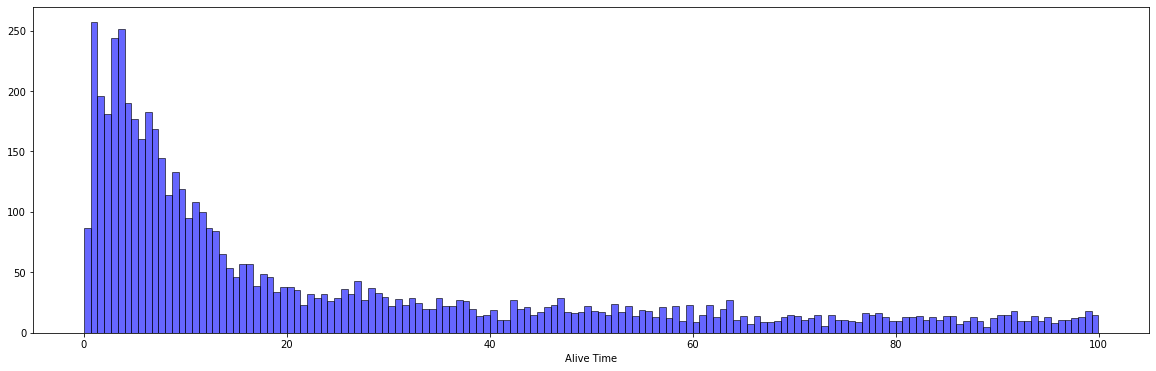

In [36]:
alive_time = alive_time.loc[alive_time['stat_amount']<100]
fig, ax = plt.subplots(figsize=(20,6)) 
plt.hist(alive_time, bins=150,facecolor="blue", edgecolor="black",alpha=0.6)
plt.xlabel("Alive Time")
plt.show()

From the chart above we can see that the right part of 0-100 is around average, after a small wave between 20 and 40 it became more stable.

Therefore, we choose 30 as our threshold to remove special cases.

In [37]:
phs_2019 = pd.read_csv('Data/phs_2019_playoffs.csv')
phs_2020_1 = pd.read_csv('Data/phs_2020_1.csv')
phs_2020_2 = pd.read_csv('Data/phs_2020_2.csv')

Then, because we are going to use every single hero's data set, removed 'All Heroes' summary data part and the unuseful columns in the set.

Function name: cleaning_aft

Description: 

This function aims at removing outliers and noise in the datasets. It is possible that some of the players switched heros temporarily. As a result, due to the short play time, it is possible that many stats of the gameplay have yet to become available. Therefore, to reduce the influence on the overall modeling, gameplay less than 30 seconds, or stats less than 6 variables will be removed.

Input:

1. csv_before [DataFrame]: It includes the data from gameplays collected from 2019 and 2020.

Output:

1. csv_before [DataFrame]: The sanitized data based on filtering rules.

In [38]:
def cleaning_aft(csv_before):
    csv_before = pre_cleansing(csv_before) 
    csv_before.drop(columns=['start_time','stage','map_type'],inplace=True)
    csv_before.drop(csv_before[(csv_before.hero == "All Heroes")].index, inplace=True) 
    return csv_before

In [ ]:
clean_df_2019 = cleaning_aft(phs_2019)
clean_df_2020_1 = cleaning_aft(phs_2020_1)
clean_df_2020_2 = cleaning_aft(phs_2020_2)
# clean_df_2021 = cleaning_aft(phs_2021)

In [54]:
frames = [clean_df_2019, clean_df_2020_1,clean_df_2020_2]
total_data = pd.concat(frames)
total_data

,match_id,map_name,player,team,stat_name,hero,stat_amount
28,30172,Ilios,Elsa,Chengdu Hunters,All Damage Done,D.Va,13934.906430
29,30172,Ilios,Elsa,Chengdu Hunters,Assists,D.Va,15.000000
30,30172,Ilios,Elsa,Chengdu Hunters,Average Time Alive,D.Va,569.509017
31,30172,Ilios,Elsa,Chengdu Hunters,Barrier Damage Done,D.Va,6703.071256
32,30172,Ilios,Elsa,Chengdu Hunters,Critical Hit Accuracy,D.Va,0.092603
...,...,...,...,...,...,...,...
473159,35552,Hollywood,tobi,Seoul Dynasty,Time Played,Mercy,919.875289
473160,35552,Hollywood,tobi,Seoul Dynasty,Ultimates Earned - Fractional,Mercy,4.811592
473161,35552,Hollywood,tobi,Seoul Dynasty,Ultimates Used,Mercy,4.000000
473162,35552,Hollywood,tobi,Seoul Dynasty,Valkyrie Healing Efficiency,Mercy,301.680441


In [41]:
total_data.hero.unique()

array(['D.Va', 'Sigma', 'Doomfist', 'Junkrat', 'Pharah', 'Lúcio', 'Moira',
       'Sombra', 'Symmetra', 'Baptiste', 'Mercy', 'Orisa',
       'Wrecking Ball', 'Zarya', 'Reaper', 'Tracer', 'Ana', 'Winston',
       'McCree', 'Widowmaker', 'Ashe', 'Mei', 'Hanzo', 'Bastion',
       'Brigitte', 'Reinhardt', 'Zenyatta', 'Roadhog', 'Genji',
       'Soldier: 76', 'Torbjörn', 'Echo'], dtype=object)

In [42]:
# number of different match_id
print('number of different match_id:', total_data.match_id.nunique())

number of different match_id: 564


In [43]:
# number of records in each match_id
total_data.match_id.value_counts()

30175    6709
37386    6023
34516    5979
37445    5362
34515    5331
         ... 
36201      54
36205      54
36202      39
36197      38
36221      37
Name: match_id, Length: 564, dtype: int64

In [44]:
match_result = pd.read_csv('annual_match_result_table.csv')
match_result

,match_year,match_id,map_name,map_winner,winning_team_final_map_score,winning_team_win_rate,map_loser,losing_team_final_map_score,losing_team_win_rate
0,2018,10223,Dorado,Los Angeles Valiant,3,0.600000,San Francisco Shock,2,0.400000
1,2018,10223,Temple of Anubis,Los Angeles Valiant,4,0.571429,San Francisco Shock,3,0.428571
2,2018,10223,Ilios,Los Angeles Valiant,2,0.666667,San Francisco Shock,1,0.333333
3,2018,10223,Numbani,Los Angeles Valiant,2,0.666667,San Francisco Shock,1,0.333333
4,2018,10224,Dorado,Los Angeles Gladiators,1,1.000000,Shanghai Dragons,0,0.000000
...,...,...,...,...,...,...,...,...,...
4511,2021,37442,Dorado,Atlanta Reign,3,0.600000,Dallas Fuel,2,0.400000
4512,2021,37441,Ilios,Shanghai Dragons,2,1.000000,Atlanta Reign,0,0.000000
4513,2021,37441,Hanamura,Shanghai Dragons,3,0.600000,Atlanta Reign,2,0.400000
4514,2021,37441,King's Row,Shanghai Dragons,6,0.545455,Atlanta Reign,5,0.454545


In [45]:
def clean_match(hero_name, match_info):
    clean_match_df = match_info.merge(match_result.iloc[:, :6], how = 'inner', left_on =['match_id', 'map_name', 'team'], right_on =['match_id', 'map_name', 'map_winner'])
    hero_info = clean_match_df[clean_match_df['hero'] == hero_name]
    if len(hero_info) == 0:
        return 'No record about the hero name: ' + hero_name
    else:
        return hero_info

In [46]:
Top_11_stat_name = list(clean_df_2019.stat_name.value_counts()[:11].index)
Top_11_stat_name

['Ultimates Earned - Fractional',
 'Time Played',
 'Time Building Ultimate',
 'Time Elapsed per Ultimate Earned',
 'Time Alive',
 'Damage Taken',
 'Healing Received',
 'All Damage Done',
 'Hero Damage Done',
 'Average Time Alive',
 'Barrier Damage Done']

In [47]:
# Top 11 stat_name in year 2019 
clean_df_2019.stat_name.value_counts()[:11]

Ultimates Earned - Fractional       2078
Time Played                         1789
Time Building Ultimate              1787
Time Elapsed per Ultimate Earned    1781
Time Alive                          1781
Damage Taken                        1779
Healing Received                    1775
All Damage Done                     1758
Hero Damage Done                    1755
Average Time Alive                  1715
Barrier Damage Done                 1702
Name: stat_name, dtype: int64

In [48]:
def prepare_data(data_set):
   data_set = data_set[data_set.stat_name.isin(Top_11_stat_name)].iloc[:, [0,1, 4, 6, 10]]
   data_set = pd.pivot_table(data_set, values = ['stat_amount'], index = ['match_id', 'map_name','winning_team_win_rate'], columns = ['stat_name'])
   data_set = data_set.apply(lambda x: x.fillna(x.mean())) 
   return data_set

There are 11 common stat_name with the highly appearance frequency. we will use these 11 stat_names to do analysis to see the relationhsip between each of them and the winning rate

Function name: regression:


Description: 

This function aims at filtering datasets we are gonna use to do linear regression. 
We do this part for nomarlization, which standarlize every stats by the metric of Time Play and quantify each data with same scale.

Input:

1. hero,stat_name [String]: Which hero or stat we are going to analyze.

Output:

1. stat,winning_rate [Array]: Two set of data we use in regression process.

In [49]:
def regression(hero,stat_name):
    data = clean_match(hero,total_data)
    data_set = prepare_data(data)
    winning_rate = data_set.index.get_level_values(2).to_numpy().reshape(-1, 1)
    play_time = data_set.iloc[:, data_set.columns.get_level_values(1)=='Time Played'].values
    stat = data_set.iloc[:, data_set.columns.get_level_values(1)== stat_name].values.reshape(-1, 1)/play_time
    stat[stat == stat.max()] = stat.mean()
    # stat[stat == stat.max()] = stat.mean()
    # stat[stat == stat.max()] = stat.mean()
    stat[stat == stat.min()] = stat.mean()
    return stat,winning_rate


In [50]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [51]:
# hero_list = ['D.Va', 'Sigma', 'Doomfist', 'Junkrat', 'Pharah', 'Lúcio', 'Moira','Sombra', 'Symmetra', 'Baptiste', 'Mercy', 'Orisa','Wrecking Ball', 'Zarya', 'Reaper', 'Tracer', 'Ana', 'Winston','McCree', 'Widowmaker', 'Ashe', 'Mei', 'Hanzo', 'Bastion','Brigitte', 'Reinhardt', 'Zenyatta', 'Roadhog', 'Genji','Soldier: 76', 'Torbjörn', 'Echo']
# stat_list = ['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned']
# x = 0
# y = 0

# fig, axs = plt.subplots(32,8,figsize=(50,200)) 
# for hero in hero_list:
#        for stat in stat_list:
#               result = regression(hero,stat)
#               stat = result[0]
#               winning_rate = result[1]
#               model.fit(stat,winning_rate)
#               # print(model.score(stat,winning_rate))
       
              
#               axs[y,x].plot(stat,winning_rate,'b.')
#               axs[y,x].plot(stat,model.predict(winning_rate))
#               x = x+1
#        x = 0
#        y = y+1
# plt.show()
           

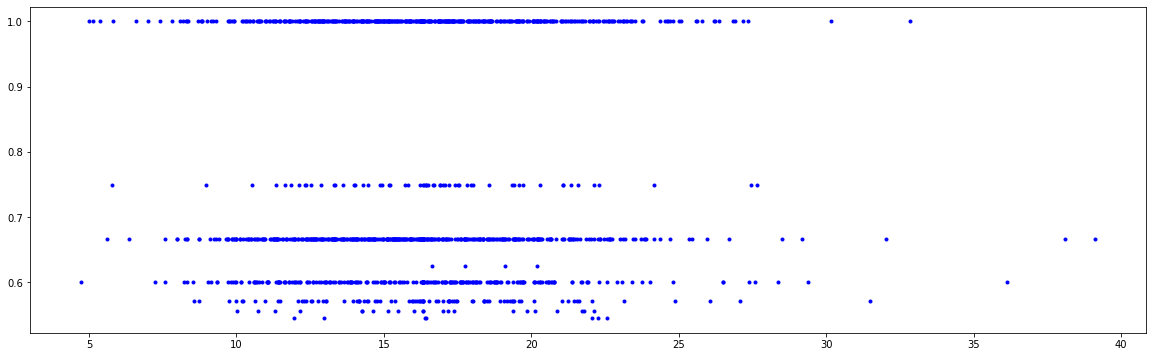

In [52]:
fig, ax = plt.subplots(figsize=(20,6)) 
result = regression('D.Va','All Damage Done')

stat = result[0]
winning_rate = result[1]
model.fit(stat,winning_rate)
    
plt.plot(stat,winning_rate,'b.')     
plt.show()

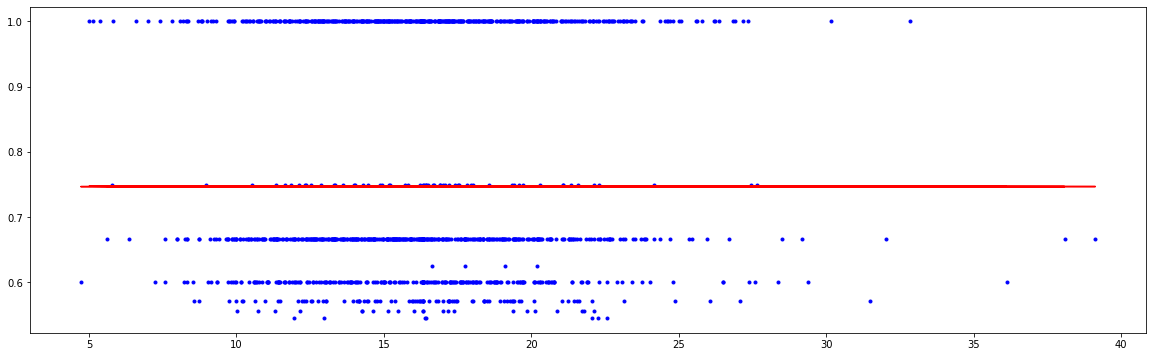

In [53]:
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(stat,winning_rate,'b.')
plt.plot(stat,model.predict(winning_rate),'r')       
plt.show()

The simple Linear Regression doesn't work.

why?

One direct and obvious reason is, the relationship between Statistics and Winning rate is NOT totally Linear!

The way Linear Regression works is by trying to find the weights that lead to the best-fitting line for the input data we have. The best-fitting line is determined in terms of lowest cost. In other words, we are trying to map one independent variable to one dependent variable. 

When the data's mapping relationship is not linear, the regression won't work.

At first glance there is something against common sense that in our feeling，when you perform well in a game, your hero stat will be high and also your chances of winning are high, showing a linear performance.

One of the important factor is that, the data we use is from OWL, Overwatch League.

In normal gameplay, stats sometimes lead to the outcome, which means the linear mapping sometimes represent a cause-and-effect relationship.

But we are talking about League, there is actually not much difference in the various values of ability level among professional e-sports players. What's also at play in the game are teamwork, the timing of various reactions, offensive and defensive tactics, and other subtle and difficult to quantify team performances. 

In other words, while each statistic in the game still contributes to the winning percentage, it is not a very decisive linear influence anymore.

Okay, now we know that we can't present the stat in linear way, then we move on the another method to standardlize the contribution of every stat in game which is not depended on linear relationship.